## Analysis of 1st day in the RCF study
Checking amygdala activation in the CS+US condition of the task
- masking amygdala
- avergaing activation
- plot

In [1]:
# load libraries
import glob
import pandas as pd
import numpy as np
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import pingouin as pg
# importing Bayesian methods

import cmdstanpy

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/_utils/helpers.py:145: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  return func(*args, **kwargs)


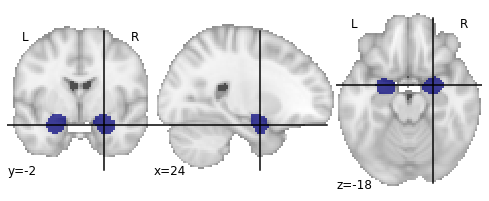

In [125]:
# load mask
mask_file = 'amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=20", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)

# create a masker 
fwhm = 4
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=fwhm, standardize=False, 
                                        detrend=False, verbose=5)

In [92]:
us_condPTSD = glob.glob('/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_PTSD/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.PTSD/SG_results/*.results/sub-*_CSpS_CSp_MNI.nii')
us_condCC = glob.glob('/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_TraumaControl/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.TraumaControl/SG_results/*.results/sub-*_CSpS_CSp_MNI.nii')


In [93]:
# grab PTSD amygdala activation
us = []
timeseriesAmg = []
for f in us_condPTSD:
    print(f)
    sub = os.path.basename(f).split('_')[0]
    print(sub)
    tArr = masker.fit_transform(f)
    meanT = np.mean(tArr,axis=1)
    sem = scipy.stats.sem(tArr, axis=1)
    std = np.std(tArr, axis=1)
    

#     # create datafram for the timeseries
    dfTS = {'subject':sub, 'ts':tArr[0]}
#     # create dataframe for the mean activation
    df = {'subject':sub, 'amygdala':meanT[0], 'amgsem':sem[0], 'amgstd':std[0]}
#     #df['subject'] = sub
    us.append(df)
    timeseriesAmg.append(dfTS)
amg_udPTSD = pd.DataFrame(us)
tsDf = pd.DataFrame(timeseriesAmg)

/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_PTSD/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.PTSD/SG_results/103.results/sub-103_CSpS_CSp_MNI.nii
sub-103
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(107, 127, 101, 1),
affine=array([[ -1.5,  -0. ,  -0. ,  79.5],
       [ -0. ,  -1.5,  -0. ,  79.5],
       [  0. ,   0. ,   1.5, -65. ],
       [  0. ,   0. ,   0. ,   1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_PTSD/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.PTSD/SG_results/105.results/sub-105_CSpS_CSp_MNI.nii
sub-105
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fi

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_PTSD/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.PTSD/SG_results/123.results/sub-123_CSpS_CSp_MNI.nii
sub-123
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(107, 127, 101, 1),
affine=array([[ -1.5,  -0. ,  -0. ,  79.5],
       [ -0. ,  -1.5,  -0. ,  79.5],
       [  0. ,   0. ,   1.5, -65. ],
       [  0. ,   0. ,   0. ,   1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_PTSD/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.PTSD/SG_results/125.results/sub-125_CSpS_CSp_MNI.nii
s

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_PTSD/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.PTSD/SG_results/166.results/sub-166_CSpS_CSp_MNI.nii
sub-166
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(107, 127, 101, 1),
affine=array([[ -1.5,  -0. ,  -0. ,  79.5],
       [ -0. ,  -1.5,  -0. ,  79.5],
       [  0. ,   0. ,   1.5, -65. ],
       [  0. ,   0. ,   0. ,   1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_PTSD/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.PTSD/SG_results/169.results/sub-169_CSpS_CSp_MNI.nii
s

In [94]:
# grab C amygdala activation
usCC = []
timeseriesAmgCC = []
for f in us_condCC:
    print(f)
    sub = os.path.basename(f).split('_')[0]
    print(sub)
    tArr = masker.fit_transform(f)
    meanT = np.mean(tArr,axis=1)
    sem = scipy.stats.sem(tArr, axis=1)
    std = np.std(tArr, axis=1)
    

#     # create datafram for the timeseries
    dfTSCC = {'subject':sub, 'ts':tArr[0]}
#     # create dataframe for the mean activation
    dfCC = {'subject':sub, 'amygdala':meanT[0], 'amgsem':sem[0], 'amgstd':std[0]}
#     #df['subject'] = sub
    usCC.append(dfCC)
    timeseriesAmgCC.append(dfTS)
amg_udCC = pd.DataFrame(usCC)
tsDfCC = pd.DataFrame(timeseriesAmgCC)

/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_TraumaControl/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.TraumaControl/SG_results/102.results/sub-102_CSpS_CSp_MNI.nii
sub-102
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(107, 127, 101, 1),
affine=array([[ -1.5,  -0. ,  -0. ,  79.5],
       [ -0. ,  -1.5,  -0. ,  79.5],
       [  0. ,   0. ,   1.5, -65. ],
       [  0. ,   0. ,   0. ,   1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_TraumaControl/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.TraumaControl/SG_results/104.results/sub-104_CSpS_CSp_MNI.nii
sub-104
[NiftiMasker.fit] Lo

[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/LissekLab_CSpS-CSp_TraumaControl/labs/lisseklab/PTSD_StimGen/Analysis/subject_results/group.TraumaControl/SG_results/160.results/sub-160_CSpS_CSp_MNI.nii
sub-160
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(107, 127, 101, 1),
affine=array([[ -1.5,  -0. ,  -0. ,  79.5],
       [ -0. ,  -1.5,  -0. ,  79.5],
       [  0. ,   0. ,   1.5, -65. ],
       [  0. ,   0. ,   0. ,   1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/Lab_Projects/RCF/neuroimaging/Lissek/Liss

[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [95]:
amg_udPTSD['group'] = "PTSD"
amg_udCC['group'] = 'CC'

amg_ud = pd.concat([amg_udPTSD, amg_udCC]).reset_index(drop=True) # reset the subject's index

# save as csv
#amg_ud.to_csv('lissek_amgCSpSvsCSp.csv', index=False)
amg_ud#.head()


,subject,amygdala,amgsem,amgstd,group
0,sub-103,0.269722,0.014017,0.331100,PTSD
1,sub-105,0.327857,0.018383,0.434249,PTSD
2,sub-106,0.147908,0.017060,0.403003,PTSD
3,sub-108,0.250330,0.013297,0.314111,PTSD
4,sub-110,0.087711,0.012650,0.298820,PTSD
5,sub-111,0.431357,0.015388,0.363490,PTSD
6,sub-115,0.282070,0.021291,0.502932,PTSD
7,sub-117,0.217272,0.012852,0.303580,PTSD
8,sub-118,0.121030,0.013345,0.315230,PTSD
9,sub-120,-0.199094,0.010314,0.243643,PTSD


## look at group differences

<AxesSubplot:title={'center':'amygdala'}, xlabel='group', ylabel='amygdala'>

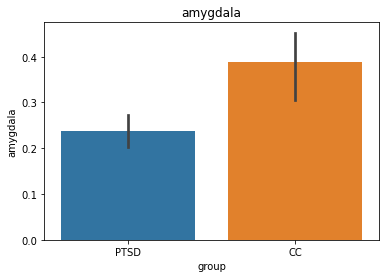

In [96]:
# Plot barplot to see differences
plt.title("amygdala")
sns.barplot(x="group", y="amygdala", data=amg_ud, ci=68)

In [97]:
# run simple one-tailed t-test
t = scipy.stats.ttest_ind(amg_ud['amygdala'][amg_ud['group']=='CC'],amg_ud['amygdala'][amg_ud['group']=='PTSD'], 
                     equal_var = True)

# one tailed
t[1] /2

0.03347196958005534

## Use Stan

In [98]:
dg = amg_ud
# changing group to numbers before we run stan model
group = {'CC': 0,'PTSD': 1} 
# setting it as new variable
dg['groupIdx'] = [group[item] for item in dg.group] 

# how many in each group
dg.groupby(['group']).count()

,subject,amygdala,amgsem,amgstd,groupIdx
group,,,,,
CC,22,22,22,22,22
PTSD,26,26,26,26,26


In [99]:
data =  {'N': len(dg), 'x': dg['groupIdx'].values, 'y': dg['amygdala'].values}
sm = cmdstanpy.CmdStanModel(stan_file='Stan_model/simple_model.stan')


In [100]:
fit_simple_model = sm.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  #inits = 0.2,
)

In [113]:
fit_simple_model.summary()#percentiles=(2.5,97.5))
#fit_simple_model.draws().shape
#fit_simple_model.draws(concat_chains=True).shape

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,35.00,0.03200,1.200,33.00,36.00,37.000,1500.0,15000.0,1.0
alpha,0.39,0.00150,0.061,0.29,0.39,0.490,1500.0,16000.0,1.0
beta,-0.15,0.00210,0.084,-0.29,-0.15,-0.014,1600.0,16000.0,1.0
sigma,0.29,0.00066,0.031,0.24,0.28,0.340,2200.0,23000.0,1.0


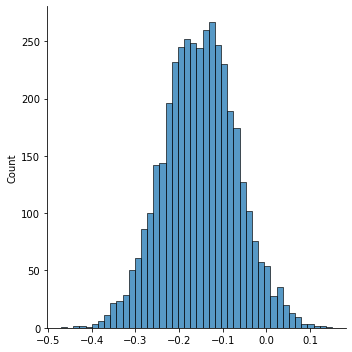

In [102]:
draws_rmu = fit_simple_model.stan_variable(name='beta')
sns.displot(draws_rmu)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.038250000000000006

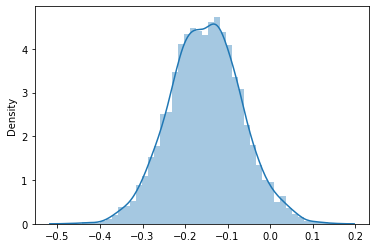

In [103]:
sns.distplot(draws_rmu)
1 - sum(draws_rmu<0) / len(draws_rmu)

# Check correlation between amg and behavior

In [114]:
dfPCL = pd.read_spss('LissekLab_PTSD_TraumaControl_motion.sav')
# remove the RCF from beginning of subject id

dfPCL
#dfPCL['Identifier'] = dfPCL['Identifier'].astype(str)
#dfPCL
# # because some subjects has two digits, we add zero
for i in dfPCL.iterrows():
   
    dfPCL.at[i[0],'subject'] = 'sub-' + str(int(i[1].Identifier))

#         dfPCL.at[i[0],'subject'] = '0' + i[1].subject

dfPCL = dfPCL.drop("Identifier", axis=1)
dfPCL.head()

,Age,Gender,CAPS_B1F,CAPS_B1I,CAPS_B1FI,CAPS_B2F,CAPS_B2I,CAPS_B2FI,CAPS_B3F,CAPS_B3I,...,PCL_9,PCL_10,PCL_11,PCL_12,PCL_13,PCL_14,PCL_15,PCL_16,PCL_17,subject
0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,sub-102
1,31.0,1.0,2.0,2.0,4.0,2.0,2.0,4.0,0.0,0.0,...,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,sub-103
2,24.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0,0.0,...,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,sub-104
3,33.0,1.0,4.0,1.0,5.0,4.0,2.0,6.0,0.0,0.0,...,4.0,3.0,1.0,1.0,3.0,3.0,4.0,3.0,2.0,sub-106
4,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,sub-107


In [115]:
dfpcl_amg = pd.merge(dfPCL, amg_ud)
dfpcl_amg['pcl_An'] = dfpcl_amg['PCL_8'] + dfpcl_amg['PCL_9'] + dfpcl_amg['PCL_10']+dfpcl_amg['PCL_11'] + dfpcl_amg['PCL_12']# = dfpcl_amg[dfpcl_amg.group.isin(groups)]

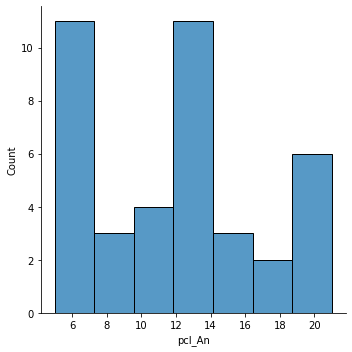

In [116]:
sns.displot(dfpcl_amg.pcl_An)

## Use function to get both R and CI
 - consider using pyStan for that also

In [117]:
def pearsonr_ci(x,y,alpha=0.05):
    from scipy import stats
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [118]:
## Correlation to two groups
pearsonr_ci(dfpcl_amg['pcl_An'], dfpcl_amg['amygdala'])

(-0.2891642145325262,
 0.07033871659343388,
 -0.5510375571823075,
 0.02455718032387665)

In [119]:
## correlation only for PTSD group
dfpcl_ptsd = dfpcl_amg[dfpcl_amg.group=='PTSD']
pearsonr_ci(dfpcl_ptsd['pcl_An'], dfpcl_ptsd['amygdala'])

(-0.2678884654193403,
 0.2534878437959274,
 -0.6351183698604467,
 0.19811851665575875)

In [120]:
## correlation only for Combat Controls group
dfpcl_cc = dfpcl_amg[dfpcl_amg.group=='CC']
pearsonr_ci(dfpcl_cc['pcl_An'], dfpcl_cc['amygdala'])

(0.02114977506637781,
 0.9294762452085035,
 -0.4253519676025872,
 0.45937120335867476)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


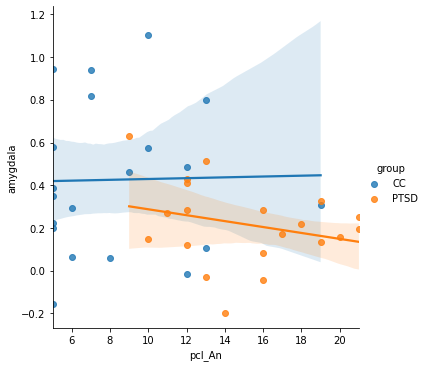

In [121]:
sns.lmplot('pcl_An', 'amygdala',hue='group', data=dfpcl_amg)

## generate publication plots

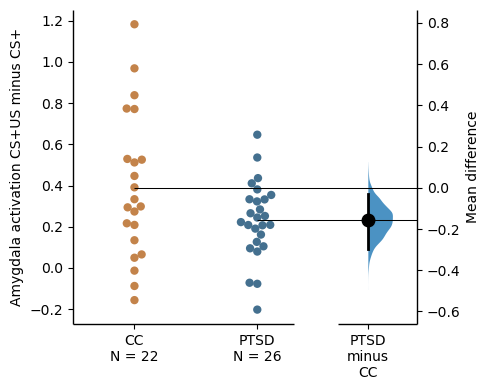

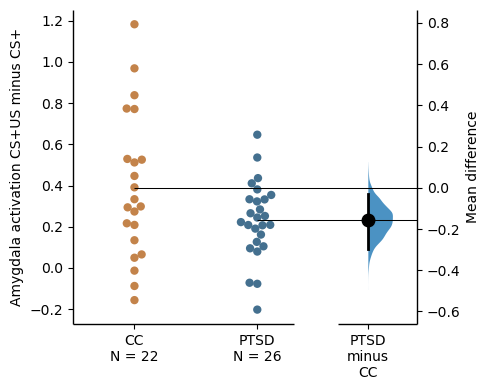

In [19]:
import dabest
groups = ["CC", "PTSD"]
dgr = amg_ud[amg_ud.group.isin(groups)]

# load our data to dabest to produce graphs
dgr = dgr.rename(columns={"amygdala": "Amygdala activation CS+US minus CS+", "group": "Group"})
dgr_dabest = dabest.load(data=dgr, x='Group', y='Amygdala activation CS+US minus CS+', idx=('CC','PTSD'), ci=90)
dgr_dabest.mean_diff.plot()

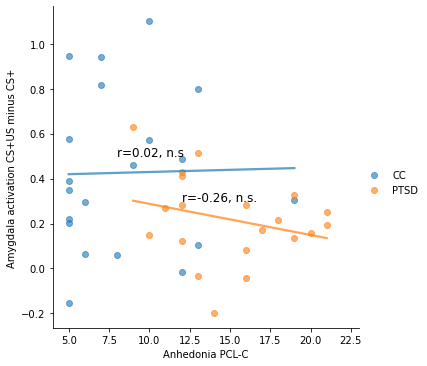

In [122]:
#fgrid = sns.lmplot(x='Anhedonia PCL5', y='Amygdala activation CS+US minus CS+',hue='group', data=dfpcl_amg, ci = None)
               #legend_out = True)
fgrid = sns.lmplot(x='pcl_An', y='amygdala',hue='group', data=dfpcl_amg,
                   ci = None, scatter_kws= {'alpha': 0.6}, line_kws={'alpha': 0.7})   
# need to add annotation- because its like facet grid we need to set each axis

ax1 = fgrid.axes[0,0]
ax1.set_xlim(4,23)
#Set labels of x and y axis
fgrid.set(xlabel='Anhedonia PCL-C', ylabel='Amygdala activation CS+US minus CS+')
ax1.text(12, .3, "r=-0.26, n.s.", horizontalalignment='left', size='large', color='black')#, weight='semibold')
ax1.text(8, .5, "r=0.02, n.s", horizontalalignment='left', size='large', color='black')#, weight='semibold')

fgrid._legend.set_title('')
#ax.annotate("An annotation")#, horizontalalignment='left', size='medium', color='black', weight='semibold')


Text(12, 0.3, 'r=-0.27, p=0.08.')

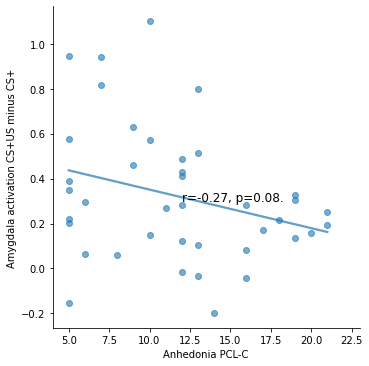

In [123]:
               #legend_out = True)
fgrid = sns.lmplot(x='pcl_An', y='amygdala', data=dfpcl_amg,
                   ci = None, scatter_kws= {'alpha': 0.6}, line_kws={'alpha': 0.7})   
# need to add annotation- because its like facet grid we need to set each axis

ax1 = fgrid.axes[0,0]
ax1.set_xlim(4,23)
#Set labels of x and y axis
fgrid.set(xlabel='Anhedonia PCL-C', ylabel='Amygdala activation CS+US minus CS+')
ax1.text(12, .3, "r=-0.27, p=0.08.", horizontalalignment='left', size='large', color='black')#, weight='semibold')

In [124]:
# Rubost regression
rub = scipy.stats.theilslopes(y=dfpcl_amg.pcl_An.values, x=dfpcl_amg.amygdala.values, alpha=0.9)
rub

(-5.036395864354372, 13.389522063109442, -9.53243487264397, 0.0)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Anhedonia PCL-C'),
 Text(0.5, 0, 'Amygdala activation CS+US minus CS+')]

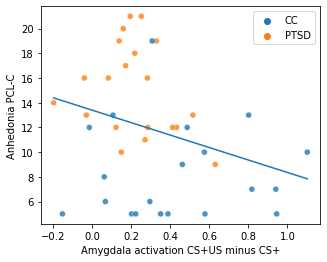

In [134]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = rub[1] + rub[0]*dfpcl_amg.amygdala
fgrid = sns.scatterplot(y='pcl_An', x='amygdala',data=dfpcl_amg, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_amg.amygdala, line)
fgrid.set(ylabel='Anhedonia PCL-C', xlabel='Amygdala activation CS+US minus CS+')

## Robust regression with Stan
- Using student t instead of normal distribution

In [44]:
data =  {'N': len(dfpcl_amg), 'x': dfpcl_amg['amygdala'].values, 'y': dfpcl_amg['pcl_An'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


In [45]:
fit_robust_reg = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  #inits = 0.2,
)

In [89]:
print(fit_robust_reg.summary().to_markdown())

| name   |   Mean |   MCSE |   StdDev |     5% |   50% |    95% |   N_Eff |   N_Eff/s |   R_hat |
|:-------|-------:|-------:|---------:|-------:|------:|-------:|--------:|----------:|--------:|
| lp__   |  -97   |  0.045 |     1.5  | -100   | -96   | -95    |    1200 |      7200 |       1 |
| alpha  |   13   |  0.031 |     1.2  |   11   |  13   |  15    |    1600 |      9500 |       1 |
| beta   |   -4.7 |  0.073 |     2.8  |   -9.3 |  -4.8 |  -0.11 |    1500 |      8800 |       1 |
| sigma  |    4.9 |  0.016 |     0.65 |    4   |   4.9 |   6.1  |    1700 |     10000 |       1 |
| nu     |   24   |  0.46  |    15    |    7.2 |  21   |  53    |    1000 |      6200 |       1 |


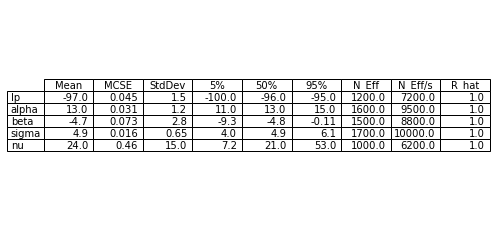

In [83]:
## Create a table
df_fit = fit_robust_reg.summary()
plt.rcParams["figure.figsize"] = [8, 4]
fig, ax =plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_fit.values,colLabels=df_fit.columns,
         rowLabels=["lp_","alpha","beta", "sigma", "nu"],loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

Comparing groups in mean SCR response

## Behavior comparison - Anhedonia, PCL and CAPS

In [ ]:
## PCL Anhedonia
print(f'CC group mean {dfpcl_cc.pcl_An.mean()} and std {dfpcl_cc.pcl_An.std()}')
print(f'PTSD group mean {dfpcl_ptsd.pcl_An.mean()} and std {dfpcl_ptsd.pcl_An.std()}')
scipy.stats.ttest_ind(dfpcl_amg.pcl_An[dfpcl_amg.group=='PTSD'], dfpcl_amg.pcl_An[dfpcl_amg.group=='CC'])

In [ ]:
## PCL total
print(f'CC group mean {dfpcl_cc.pcl_total.mean()} and std {dfpcl_cc.pcl_total.std()}')
print(f'PTSD group mean {dfpcl_ptsd.pcl_total.mean()} and std {dfpcl_ptsd.pcl_total.std()}')
scipy.stats.ttest_ind(dfpcl_amg.pcl_total[dfpcl_amg.group=='PTSD'], dfpcl_amg.pcl_total[dfpcl_amg.group=='CC'])

In [ ]:
## CAPS
capsDF = pd.read_csv('CAPSScores.csv')
#capsDF = capsDF.rename(columns={"subject_id": "subject"})
for i in capsDF.iterrows():
    
    try:
        sub = i[1].subject.split('RCF')[1]
        capsDF.at[i[0], 'subject'] = sub
    except:
        print('no')

In [ ]:
capsD = pd.merge(capsDF, amg_ud )

In [ ]:
## PCL total
#print(f'CC group mean {} and std {capsD.caps_totalscorel[capsD.group=='CC'].std()}')
#print(f'PTSD group mean {capsD.caps_totalscorel.mean()} and std {capsD.caps_totalscorel.std()}')
scipy.stats.ttest_ind(capsD.caps_totalscorel[capsD.group=='PTSD'], capsD.caps_totalscorel[capsD.group=='CC'])

In [ ]:
print(capsD.caps_totalscorel[capsD.group=='CC'].mean())
print(capsD.caps_totalscorel[capsD.group=='CC'].std())

In [ ]:
print(capsD.caps_totalscorem[capsD.group=='CC'].mean())
print(capsD.caps_totalscorem[capsD.group=='CC'].std())

In [ ]:
scipy.stats.ttest_ind(capsD.caps_totalscorem[capsD.group=='PTSD'], capsD.caps_totalscorem[capsD.group=='CC'])

## Bayes factor - 
- We use rpy2 to call for the R package BayesFactor
- Entering the simple T test to get the BF

In [ ]:
from rpy2.robjects.packages import importr
bf = importr("BayesFactor")

In [ ]:
# Calculate SCR response
a = bf.ttest_tstat(t=1.07, n1=18, n2=19)

In [ ]:
1/np.exp(a[0])

In [ ]:
# calculate shock levels
1/np.exp(bf.ttest_tstat(t=0.42, n1=16, n2=14)[0])

In [ ]:
# calculate CAPS lifetime
1/np.exp(bf.ttest_tstat(t=12.46, n1=18, n2=19)[0])

In [ ]:
# calculate CAPS last month
1/np.exp(bf.ttest_tstat(t=12.51, n1=18, n2=19)[0])

In [ ]:
# calculate PCL anhedonia
1/np.exp(bf.ttest_tstat(t=4.5, n1=18, n2=19)[0])

In [ ]:
# calculate PCL total
1/np.exp(bf.ttest_tstat(t=5.16, n1=18, n2=19)[0])

In [ ]:
# calculate Age
1/np.exp(bf.ttest_tstat(t=0.92, n1=18, n2=19)[0])

## compare if there's significant difference between correlations of CC and PTSD with anhedonia

In [ ]:
from corrstats import independent_corr
checkCorr = independent_corr(-0.57, 0.08, n=18, n2 = 19, twotailed=True,
                             conf_level=0.95, method='fisher')
print(f'Correlation difference between CC and PTSD with anhedonia is {checkCorr}')

In [ ]:
# save amygdala and other file as csv
#dfpcl_amg.to_csv('amygdala_pcl_RCF.csv', index=False)

## Robust regression

In [ ]:
X = dfpcl_amg.amygdala.values#.reshape(-1,1)
y = dfpcl_amg.pcl_An.values#.reshape(-1,1)

In [ ]:
scipy.stats.theilslopes(y, X)

In [ ]:
print(f'PTSD {scipy.stats.theilslopes(dfpcl_ptsd.pcl_An, dfpcl_ptsd.amygdala)}')
print(f'CC {(scipy.stats.theilslopes(dfpcl_cc.pcl_An, dfpcl_cc.amygdala))}')

In [ ]:
# linear regression
scipy.stats.linregress(dfpcl_cc.amygdala, dfpcl_cc.pcl_An)